In [1]:
import sys
import time
import torch
import cv2
import numpy as np
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt
from pathlib import Path

# Print environment info (from original Cell 1)
print("Python:", sys.version.splitlines()[0])
print("Torch:", torch.__version__)
print("Torch CUDA build:", getattr(torch.version, "cuda", None))
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print("GPU:", torch.cuda.get_device_name(0))
        print("Device count:", torch.cuda.device_count())
    except Exception as e:
        print("GPU query error:", e)

Python: 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]
Torch: 2.8.0+cu128
Torch CUDA build: 12.8
CUDA available: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Device count: 1


In [2]:
# --- Tweakable Parameters ---
# All configurable parameters are here for easy tweaking.
# Adjust these and re-run the processing cells to see changes.

# Page Detection and Cropping
MIN_AREA_FRAC = 0.08  # Minimum area fraction for detected contour to be considered a page
CANNY_LOW = 50        # Canny edge detection low threshold
CANNY_HIGH = 150      # Canny edge detection high threshold
GAUSSIAN_BLUR_KERNEL = (5, 5)  # Gaussian blur kernel for edge detection
DILATE_KERNEL_SIZE = (5, 5)    # Dilation kernel for edges
DILATE_ITERATIONS = 1          # Number of dilation iterations

# Preprocessing for OCR
BILATERAL_D = 5                # Bilateral filter diameter
BILATERAL_SIGMA_COLOR = 50     # Bilateral filter sigma color
BILATERAL_SIGMA_SPACE = 50     # Bilateral filter sigma space
CLAHE_CLIP_LIMIT = 2.0         # CLAHE clip limit
CLAHE_TILE_GRID = (8, 8)       # CLAHE tile grid size
TARGET_SHORT_SIDE = 0       # Target short side length for resizing (0 to disable resize)

# Additional Preprocessing Steps (inspired by OpenCV-Preprocess.ipynb)
DO_INVERT = False              # Invert the image colors (useful for white text on black)
BINARIZATION_THRESHOLD = 175   # Threshold for binarization (0-255)
BINARIZATION_MAX = 255         # Max value for binarization
DO_BINARIZE = True             # Apply binarization (thresholding)
ERODE_KERNEL_SIZE = (3, 3)     # Erosion kernel (for thinning text)
ERODE_ITERATIONS = 1           # Erosion iterations
DILATE_KERNEL_SIZE = (3, 3)    # Dilation kernel (for thickening text)
DILATE_ITERATIONS = 1          # Dilation iterations
DO_DESKEW = False               # Apply deskewing (rotation correction)
DESKEW_MIN_ANGLE = -15         # Min angle for deskew search
DESKEW_MAX_ANGLE = 15          # Max angle for deskew search
DESKEW_STEPS = 0.1             # Angle step for deskew search
REMOVE_BORDER_FRAC = 0.025      # Fraction of image size to crop as border (0 to disable)
ADD_BORDER_PADDING = 5        # Pixels to add as border padding (white)
ADD_BORDER_COLOR = (255, 255, 255)  # Border color (BGR)

# OCR Settings
OCR_LANG = "Latin+osd"         # Tesseract language (e.g., "eng" for English, or "Latin")
OCR_CONFIG = "--psm 6"         # Tesseract config (e.g., --psm 6 for single block of text)

# Input/Output Paths
IMG_PATH = Path("/home/hlatsiieyhax/GPU_Jupyter/ocr-process/data/test/Ukuvuka-kukaZanemvula-143.png")  # Change to your image path
OUT_DIR = Path("/home/hlatsiieyhax/GPU_Jupyter/ocr-process/data/test/ocr_test_outputs")  # Output directory

In [3]:
import sys
import time
import torch
import cv2
import numpy as np
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt
from pathlib import Path

# --- Utility Functions (from original) ---
def load_img(path):
    path = str(path)
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {path}")
    return img

def save_img(path, img):
    ext = Path(path).suffix or ".png"
    ok, buf = cv2.imencode(ext, img)
    if not ok:
        raise IOError("imencode failed")
    buf.tofile(str(path))

# --- Page Detection and Cropping (refined from original) ---
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts, dst_size=None):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))
    if dst_size is not None:
        (maxWidth, maxHeight) = dst_size
    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight),
                                 flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return warped

def detect_page_and_crop(img_bgr):
    h, w = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, GAUSSIAN_BLUR_KERNEL, 0)
    edges = cv2.Canny(blur, CANNY_LOW, CANNY_HIGH)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, DILATE_KERNEL_SIZE)
    edges = cv2.dilate(edges, kernel, iterations=DILATE_ITERATIONS)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4:
            area = cv2.contourArea(approx)
            if area > MIN_AREA_FRAC * h * w:
                return four_point_transform(img_bgr, approx.reshape(4, 2).astype("float32"))
    # Fallback: central crop to remove borders
    m = int(REMOVE_BORDER_FRAC * min(w, h))
    return img_bgr[m:h - m, m:w - m].copy()

# --- Deskewing (new, from OpenCV reference) ---
def deskew_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

# --- Preprocessing Pipeline (refined and expanded) ---
def preprocess_for_ocr(img_bgr):
    # Step 1: Invert if needed
    if DO_INVERT:
        img_bgr = cv2.bitwise_not(img_bgr)
    
    # Step 2: Deskew if enabled
    if DO_DESKEW:
        img_bgr = deskew_image(img_bgr)
    
    # Step 3: Bilateral filter for denoising
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = cv2.bilateralFilter(img_rgb, d=BILATERAL_D, sigmaColor=BILATERAL_SIGMA_COLOR, sigmaSpace=BILATERAL_SIGMA_SPACE)
    
    # Step 4: CLAHE on L channel for contrast enhancement
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP_LIMIT, tileGridSize=CLAHE_TILE_GRID)
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2, a, b))
    img_rgb2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
    
    # Step 5: Binarization (thresholding) if enabled
    if DO_BINARIZE:
        gray = cv2.cvtColor(img_rgb2, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, BINARIZATION_THRESHOLD, BINARIZATION_MAX, cv2.THRESH_BINARY)
        img_rgb2 = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)  # Convert back to RGB for consistency
    
    # Step 6: Erosion and Dilation (morphological ops for text refinement)
    kernel_erode = np.ones(ERODE_KERNEL_SIZE, np.uint8)
    kernel_dilate = np.ones(DILATE_KERNEL_SIZE, np.uint8)
    img_rgb2 = cv2.erode(img_rgb2, kernel_erode, iterations=ERODE_ITERATIONS)
    img_rgb2 = cv2.dilate(img_rgb2, kernel_dilate, iterations=DILATE_ITERATIONS)
    
    # Step 7: Resize to target short side if specified
    h, w = img_rgb2.shape[:2]
    short = min(h, w)
    if TARGET_SHORT_SIDE > 0 and short != TARGET_SHORT_SIDE:
        scale = TARGET_SHORT_SIDE / short
        new_w = int(round(w * scale))
        new_h = int(round(h * scale))
        img_rgb2 = cv2.resize(img_rgb2, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Step 8: Add borders if needed
    if ADD_BORDER_PADDING > 0:
        top = bottom = left = right = ADD_BORDER_PADDING
        img_rgb2 = cv2.copyMakeBorder(img_rgb2, top, bottom, left, right, cv2.BORDER_CONSTANT, value=ADD_BORDER_COLOR)
    
    # Convert to PIL for Tesseract
    return Image.fromarray(img_rgb2)

# --- OCR Inference ---
def ocr_infer_pil(image_pil):
    return pytesseract.image_to_string(image_pil, lang=OCR_LANG, config=OCR_CONFIG)

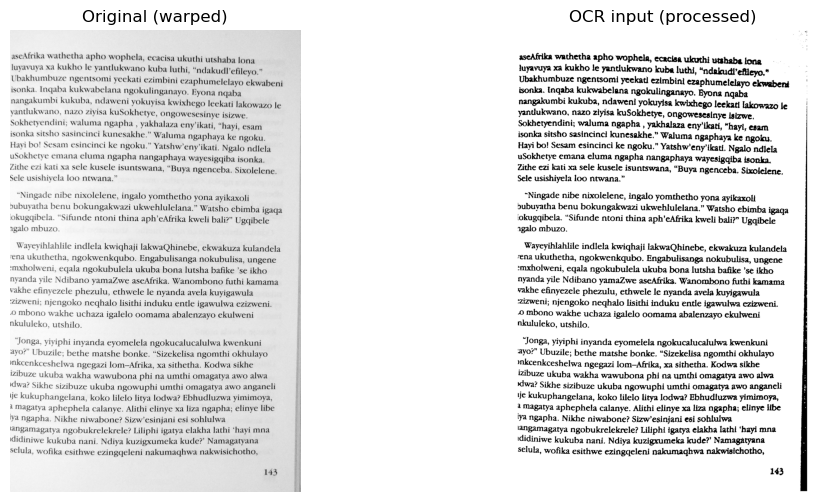

Running OCR (this may take time)...

--- OCR output (took 3.67s) ---

aseAfrika wathetha apho wophela, ecacisa ukuthi utshaba lona o ,
luyavuya xa kukho le yantlukwano kuba luthi, “ndakudlefileyo,* `
Ubakhumbuze ngentsomi yeekatl ezimbini ezaphumelelayo ekwabent `
isonka. Inqaba kukwabelana ngokulinganayo. Eyona ngaba
nangakumbi kukuba, ndaweni yokuyisa kwixhego leekati lakowazole |
yantlukwano, nazo zlyisa kuSokhetye, ongowesesinye isizwe,
Sokhetyendini; waluma ngapha , yakhalaza eny'ikati, “hayi, esam
isonka sitsħo sasincinci kunesakhe.” Waluma ngaphaya ke ngoku.
Hayi bo! Sesam esincinci ke ngoku.” Yatshw'eny’ikati. Ngalo ndiela
uSokhetye emana eluma ngapha nangaphaya wayesigqiba isonka.
Zithe ezi kati xa sele kusele isuntswana, “Buya ngenceba, Sixolelene,
Sele usishiyela loo ntwana.”

“Ningade nibe nixolelene, ingalo yomthetho yona ayikaxoli
bubuyatha benu bokungakwazi ukwehlulelana.” Watsho ebimba igaqa
lokugqibela. “Sifunde ntoni thina aph'eAfrika kweli bali?” Ugqibele
galo mbuzo.

In [4]:
import sys
import time
import torch
import cv2
import numpy as np
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt
from pathlib import Path

# --- Main Batch Processing ---
# Ensure directories exist
RAW_DIR = Path("data/raw data")
OUT_DIR = Path("data/output")
TMP_DIR = Path("data/tmp")
OUT_DIR.mkdir(exist_ok=True)
TMP_DIR.mkdir(exist_ok=True)

# Find all book subdirectories
book_dirs = sorted([d for d in RAW_DIR.iterdir() if d.is_dir()])

for book_dir in book_dirs:
    book_name = book_dir.name
    # Find and sort images (assuming naming like book_name_1.png, etc.)
    images = sorted(book_dir.glob("*.png"), key=lambda p: int(p.stem.split('_')[-1]) if '_' in p.stem else 0)
    if not images:
        print(f"No images found in {book_dir}. Skipping.")
        continue
    
    # Process first image for preview
    first_path = images[0]
    print(f"Previewing first image for {book_name}: {first_path}")
    orig = load_img(first_path)
    cropped = detect_page_and_crop(orig)
    ocr_in = preprocess_for_ocr(cropped)
    
    # Save previews
    save_img(TMP_DIR / "preview_org.png", orig)
    save_img(TMP_DIR / "preview_int.png", cv2.cvtColor(np.array(ocr_in), cv2.COLOR_RGB2BGR))
    
    # Display
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(ocr_in)
    plt.title("Processed")
    plt.axis('off')
    plt.show()
    
    # Ask for confirmation
    response = input(f"Confirm preprocessing for {book_name}? (y/yes to proceed, anything else to stop): ").strip().lower()
    if response not in ['y', 'yes']:
        print("Stopping for parameter tweaks. Adjust parameters in the previous cell and re-run this cell.")
        break
    
    # Proceed to batch process all images in this book
    print(f"Processing all {len(images)} images for {book_name}...")
    texts = []
    for idx, img_path in enumerate(images, 1):
        print(f"Processing {img_path} ({idx}/{len(images)})")
        orig = load_img(img_path)
        cropped = detect_page_and_crop(orig)
        ocr_in = preprocess_for_ocr(cropped)
        text = ocr_infer_pil(ocr_in)
        texts.append(f"--- Page {idx} ({img_path.name}) ---\n{text}\n")
    
    # Save combined text
    full_text = "\n".join(texts)
    out_path = OUT_DIR / f"{book_name}.txt"
    out_path.write_text(full_text, encoding="utf-8")
    print(f"Saved OCR output for {book_name} to {out_path}")